Violence Detection System Using ResNet50

In [56]:
from IPython.display import HTML
from base64 import b64encode
import imgaug.augmenters as iaa
import math

import numpy as np
import cv2
import os
from keras.models import load_model
from collections import deque
from tqdm import tqdm
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib
matplotlib.use("Agg")
from keras.layers import Input
from keras.models import Model
from keras.layers.core import Dense
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50V2
from keras import regularizers
from keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import seaborn as sns
from sklearn import metrics

In [57]:
PROJECT_DIR = 'D:/Education/VIT M.Tech/Semester 1/Courses/Study Oriented Project/DataSets/Real Life Violence Dataset'

In [59]:

from base64 import b64encode

def play(filename):
    html = ''
    video = open(filename,'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=640 muted controls autoplay loop><source src="%s" type="video/mp4"></video>' % src 
    return HTML(html)

In [60]:
play('D:/Education/VIT M.Tech/Semester 1/Courses/Study Oriented Project/DataSets/Real Life Violence Dataset/Real Life Violence Dataset/Violence/V_192.mp4')

In [61]:
IMG_SIZE = 128
ColorChannels = 3

def video_to_frames(video):
    vidcap = cv2.VideoCapture(video)
    
    
    rate = math.floor(vidcap.get(3))
    count = 0
    
    ImageFrames = []
    while vidcap.isOpened():
        ID = vidcap.get(1)
        success, image = vidcap.read()
        
        if success:
            # skipping frames to avoid duplications 
            if (ID % 7 == 0):
                flip = iaa.Fliplr(1.0)
                zoom = iaa.Affine(scale=1.3)
                random_brightness = iaa.Multiply((1, 1.3))
                rotate = iaa.Affine(rotate=(-25, 25))
                
                image_aug = flip(image = image)
                image_aug = random_brightness(image = image_aug)
                image_aug = zoom(image = image_aug)
                image_aug = rotate(image = image_aug)
                
                rgb_img = cv2.cvtColor(image_aug, cv2.COLOR_BGR2RGB)
                resized = cv2.resize(rgb_img, (IMG_SIZE, IMG_SIZE))
                ImageFrames.append(resized)
                
            count += 1
        else:
            break
    
    vidcap.release()
    
    return ImageFrames

Function to split the video into frames to analyse.

In [62]:
%%time
from tqdm import tqdm

VideoDataDir = PROJECT_DIR + '/Real Life Violence Dataset'
print('we have \n{} Violence videos \n{} NonViolence videos'.format(
              len(os.listdir(VideoDataDir + '/Violence')), 
              len(os.listdir(VideoDataDir + '/NonViolence'))))

X_original = []
y_original = []

print('Choosing 200 videos out of 1000 for each, cuz of memory issue')
CLASSES = ["NonViolence", "Violence"]


for category in os.listdir(VideoDataDir):
    path = os.path.join(VideoDataDir, category)
    class_num = CLASSES.index(category)
    for i, video in enumerate(tqdm(os.listdir(path)[0:200])):
        frames = video_to_frames(path + '/' + video)
        for j, frame in enumerate(frames):
            X_original.append(frame)
            y_original.append(class_num)

we have 
1000 Violence videos 
1000 NonViolence videos
Choosing 200 videos out of 1000 for each, cuz of memory issue


100%|██████████| 200/200 [00:32<00:00,  6.07it/s]

CPU times: total: 37.2 s
Wall time: 56 s


Creating Violence and Non Violence Dataset and using 200 images due to RAM constraints.

In [63]:
X_original = np.array(X_original).reshape(-1 , IMG_SIZE * IMG_SIZE * 3)
y_original = np.array(y_original)
len(X_original)

7990

In [64]:
stratified_sample = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=73)

for train_index, test_index in stratified_sample.split(X_original, y_original):
    X_train, X_test = X_original[train_index], X_original[test_index]
    y_train, y_test = y_original[train_index], y_original[test_index]

X_train_nn = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255
X_test_nn = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255

Reshaping the image and using Stratified Shuffle Split.

In [65]:
epochs = 150


kernel_regularizer = regularizers.l2(0.001)


def load_layers():
    input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, ColorChannels))
    baseModel = ResNet50V2(weights = "imagenet", pooling='avg',
                            include_top=False, 
                            input_tensor=input_tensor)
    
    headModel = baseModel.output   
    headModel = Dense(1, activation="sigmoid")(headModel)
    model = Model(inputs=baseModel.input, outputs=headModel)

    for layer in baseModel.layers:
        layer.trainable = False

    print("Compiling model...")
    model.compile(loss="binary_crossentropy",
                    optimizer='adam',
                    metrics=["accuracy"])

    return model


model = load_layers()

model.summary()

Compiling model...
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 66, 66, 64)   0           ['conv1_

 vation)                                                                                          
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 32, 32, 64)   16384       ['conv2_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 32, 32, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 32, 32, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
          

 conv3_block2_2_bn (BatchNormal  (None, 16, 16, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 16, 16, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 16, 16, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_block2_out (Add)         (None, 16, 16, 512)  0           ['conv3_block1_out[0][0]',       
                                                                  'conv3_block2_3_conv[0][0]']    
          

                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, 8, 8, 256)   1024        ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_2_pad (ZeroPaddin  (None, 10, 10, 256)  0          ['conv4_block1_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv4_blo

 conv4_block3_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block3_2_relu[0][0]']    
                                                                                                  
 conv4_block3_out (Add)         (None, 8, 8, 1024)   0           ['conv4_block2_out[0][0]',       
                                                                  'conv4_block3_3_conv[0][0]']    
                                                                                                  
 conv4_block4_preact_bn (BatchN  (None, 8, 8, 1024)  4096        ['conv4_block3_out[0][0]']       
 ormalization)                                                                                    
                                                                                                  
 conv4_block4_preact_relu (Acti  (None, 8, 8, 1024)  0           ['conv4_block4_preact_bn[0][0]'] 
 vation)                                                                                          
          

 g2D)                                                                                             
                                                                                                  
 conv4_block6_2_conv (Conv2D)   (None, 4, 4, 256)    589824      ['conv4_block6_2_pad[0][0]']     
                                                                                                  
 conv4_block6_2_bn (BatchNormal  (None, 4, 4, 256)   1024        ['conv4_block6_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block6_2_relu (Activatio  (None, 4, 4, 256)   0           ['conv4_block6_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 max_pooli

 ormalization)                                                                                    
                                                                                                  
 conv5_block3_preact_relu (Acti  (None, 4, 4, 2048)  0           ['conv5_block3_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv5_block3_1_conv (Conv2D)   (None, 4, 4, 512)    1048576     ['conv5_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, 4, 4, 512)   2048        ['conv5_block3_1_conv[0][0]']    
 ization)                                                                                         
          

Training the model for 150 epochs using ResNet50V2 and using imagenet weights.

In [66]:
patience = 3

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005

batch_size = 20



rampup_epochs = 30
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr


class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if ((logs.get('accuracy')>=0.99)):
            print("\nLimits Reached cancelling training!")
            self.model.stop_training = True

Stopping early if the accuracy is >= 99%.

In [67]:
end_callback = myCallback()

lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=False)

early_stopping = EarlyStopping(patience = patience, monitor='val_loss',
                                 mode='min', restore_best_weights=True, 
                                 verbose = 1, min_delta = .00075)



lr_plat = ReduceLROnPlateau(patience = 2, mode = 'min')

os.system('rm -rf ./logs/')


log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir = log_dir, write_graph=True, histogram_freq=1)

checkpoint_filepath = 'ModelWeights.h5'

model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor='val_loss',
                                        mode='min',
                                        verbose = 1,
                                        save_best_only=True)


callbacks = [end_callback, lr_callback, model_checkpoints, tensorboard_callback, early_stopping, lr_plat]

Callback function to save weights if the loss is reduced.

In [68]:
print('Training head...')
batch_size = 50
#model.load_weights('./Model_Weights.h5')

history = model.fit(X_train_nn ,y_train, epochs=epochs,
                        callbacks=callbacks,
                        validation_data = (X_test_nn, y_test),
                        batch_size=batch_size)

print('\nRestoring best Weights for ResNet50V2')
model.load_weights(checkpoint_filepath)

Training head...
Epoch 1/150
112/112 [==============================] - ETA: 0s - loss: 0.8753 - accuracy: 0.4963
Epoch 1: val_loss improved from inf to 0.83404, saving model to ModelWeights.h5
112/112 [==============================] - 70s 598ms/step - loss: 0.8753 - accuracy: 0.4963 - val_loss: 0.8340 - val_accuracy: 0.5232 - lr: 1.0000e-05
Epoch 2/150
112/112 [==============================] - ETA: 0s - loss: 0.8075 - accuracy: 0.5326
Epoch 2: val_loss improved from 0.83404 to 0.77266, saving model to ModelWeights.h5
112/112 [==============================] - 73s 653ms/step - loss: 0.8075 - accuracy: 0.5326 - val_loss: 0.7727 - val_accuracy: 0.5594 - lr: 1.1333e-05
Epoch 3/150
112/112 [==============================] - ETA: 0s - loss: 0.7457 - accuracy: 0.5759
Epoch 3: val_loss improved from 0.77266 to 0.71455, saving model to ModelWeights.h5
112/112 [==============================] - 72s 649ms/step - loss: 0.7457 - accuracy: 0.5759 - val_loss: 0.7146 - val_accuracy: 0.5957 - lr: 1.

Epoch 26/150
112/112 [==============================] - ETA: 0s - loss: 0.1920 - accuracy: 0.9335
Epoch 26: val_loss improved from 0.20456 to 0.19831, saving model to ModelWeights.h5
112/112 [==============================] - 67s 597ms/step - loss: 0.1920 - accuracy: 0.9335 - val_loss: 0.1983 - val_accuracy: 0.9278 - lr: 4.3333e-05
Epoch 27/150
112/112 [==============================] - ETA: 0s - loss: 0.1853 - accuracy: 0.9362
Epoch 27: val_loss improved from 0.19831 to 0.19224, saving model to ModelWeights.h5
112/112 [==============================] - 67s 598ms/step - loss: 0.1853 - accuracy: 0.9362 - val_loss: 0.1922 - val_accuracy: 0.9303 - lr: 4.4667e-05
Epoch 28/150
112/112 [==============================] - ETA: 0s - loss: 0.1790 - accuracy: 0.9387
Epoch 28: val_loss improved from 0.19224 to 0.18662, saving model to ModelWeights.h5
112/112 [==============================] - 67s 598ms/step - loss: 0.1790 - accuracy: 0.9387 - val_loss: 0.1866 - val_accuracy: 0.9307 - lr: 4.6000e-0

112/112 [==============================] - 66s 590ms/step - loss: 0.1297 - accuracy: 0.9585 - val_loss: 0.1463 - val_accuracy: 0.9495 - lr: 1.0576e-05
Epoch 51/150
112/112 [==============================] - ETA: 0s - loss: 0.1289 - accuracy: 0.9587
Epoch 51: val_loss improved from 0.14629 to 0.14566, saving model to ModelWeights.h5
112/112 [==============================] - 66s 591ms/step - loss: 0.1289 - accuracy: 0.9587 - val_loss: 0.1457 - val_accuracy: 0.9499 - lr: 1.0461e-05
Epoch 52/150
112/112 [==============================] - ETA: 0s - loss: 0.1281 - accuracy: 0.9592
Epoch 52: val_loss improved from 0.14566 to 0.14496, saving model to ModelWeights.h5
112/112 [==============================] - 66s 593ms/step - loss: 0.1281 - accuracy: 0.9592 - val_loss: 0.1450 - val_accuracy: 0.9508 - lr: 1.0369e-05
Epoch 53/150
112/112 [==============================] - ETA: 0s - loss: 0.1274 - accuracy: 0.9596
Epoch 53: val_loss improved from 0.14496 to 0.14430, saving model to ModelWeights.h

Epoch 100/150
112/112 [==============================] - ETA: 0s - loss: 0.0999 - accuracy: 0.9680
Epoch 100: val_loss improved from 0.12192 to 0.12156, saving model to ModelWeights.h5
112/112 [==============================] - 163s 1s/step - loss: 0.0999 - accuracy: 0.9680 - val_loss: 0.1216 - val_accuracy: 0.9612 - lr: 1.0000e-05
Epoch 101/150
112/112 [==============================] - ETA: 0s - loss: 0.0995 - accuracy: 0.9680
Epoch 101: val_loss improved from 0.12156 to 0.12117, saving model to ModelWeights.h5
112/112 [==============================] - 166s 1s/step - loss: 0.0995 - accuracy: 0.9680 - val_loss: 0.1212 - val_accuracy: 0.9612 - lr: 1.0000e-05
Epoch 102/150
112/112 [==============================] - ETA: 0s - loss: 0.0991 - accuracy: 0.9680
Epoch 102: val_loss improved from 0.12117 to 0.12084, saving model to ModelWeights.h5
112/112 [==============================] - 162s 1s/step - loss: 0.0991 - accuracy: 0.9680 - val_loss: 0.1208 - val_accuracy: 0.9612 - lr: 1.0000e-0

112/112 [==============================] - 71s 634ms/step - loss: 0.0902 - accuracy: 0.9726 - val_loss: 0.1139 - val_accuracy: 0.9625 - lr: 1.0000e-05
Epoch 125/150
112/112 [==============================] - ETA: 0s - loss: 0.0899 - accuracy: 0.9730
Epoch 125: val_loss improved from 0.11386 to 0.11358, saving model to ModelWeights.h5
112/112 [==============================] - 71s 633ms/step - loss: 0.0899 - accuracy: 0.9730 - val_loss: 0.1136 - val_accuracy: 0.9629 - lr: 1.0000e-05
Epoch 126/150
112/112 [==============================] - ETA: 0s - loss: 0.0895 - accuracy: 0.9725
Epoch 126: val_loss improved from 0.11358 to 0.11329, saving model to ModelWeights.h5
112/112 [==============================] - 70s 630ms/step - loss: 0.0895 - accuracy: 0.9725 - val_loss: 0.1133 - val_accuracy: 0.9629 - lr: 1.0000e-05
Epoch 127/150
112/112 [==============================] - ETA: 0s - loss: 0.0892 - accuracy: 0.9735
Epoch 127: val_loss improved from 0.11329 to 0.11303, saving model to ModelWei

In [69]:
%matplotlib inline

def print_graph(item, index, history):
    plt.figure()
    train_values = history.history[item][0:index]
    plt.plot(train_values)
    test_values = history.history['val_' + item][0:index]
    plt.plot(test_values)
    plt.legend(['training','validation'])
    plt.title('Training and validation '+ item)
    plt.xlabel('epoch')
    plt.show()
    plot = '{}.png'.format(item)
    plt.savefig(plot)


def get_best_epoch(test_loss, history):
    for key, item in enumerate(history.history.items()):
        (name, arr) = item
        if name == 'val_loss':
            for i in range(len(arr)):
                if round(test_loss, 2) == round(arr[i], 2):
                    return i
                
def model_summary(model, history):
    print('---'*30)
    test_loss, test_accuracy = model.evaluate(X_test_nn, y_test, verbose=0)

    if history:
        index = get_best_epoch(test_loss, history)
        print('Best Epochs: ', index)

        train_accuracy = history.history['accuracy'][index]
        train_loss = history.history['loss'][index]

        print('Accuracy on train:',train_accuracy,'\tLoss on train:',train_loss)
        print('Accuracy on test:',test_accuracy,'\tLoss on test:',test_loss)
        print_graph('loss', index, history)
        print_graph('accuracy', index, history)
        print('---'*30)

------------------------------------------------------------------------------------------
Best Epochs:  120
Accuracy on train: 0.9719291925430298 	Loss on train: 0.09134931117296219
Accuracy on test: 0.9628702402114868 	Loss on test: 0.10989063233137131


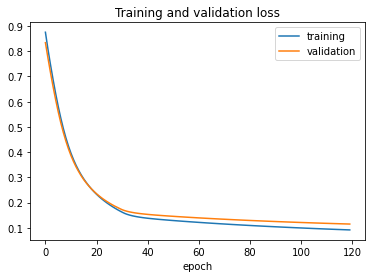

<Figure size 432x288 with 0 Axes>

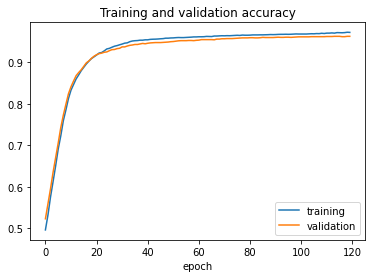

------------------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

In [70]:
model_summary(model, history)

Training and validation accuracy is increasing while the loss is decreasing.

In [71]:
print("Evaluating network...")
predictions = model.predict(X_test_nn)
preds = predictions > 0.6

Evaluating network...
75/75 [==============================] - 50s 647ms/step


Only choosing those images where the prediction accuracy is more than 60% sure whether the images are violence or non violence.

> Correct Predictions: 2305
> Wrong Predictions: 92


C:\Users\Srirag\AppData\Local\Temp\ipykernel_2740\231354494.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n_correct = np.int((corr_pred[0][0] + corr_pred[1][1]))
C:\Users\Srirag\AppData\Local\Temp\ipykernel_2740\231354494.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, che

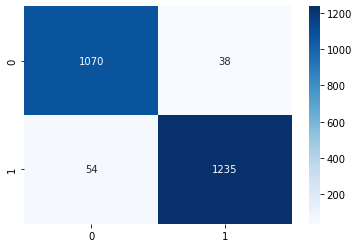

              precision    recall  f1-score   support

 NonViolence       0.95      0.97      0.96      1108
    Violence       0.97      0.96      0.96      1289

    accuracy                           0.96      2397
   macro avg       0.96      0.96      0.96      2397
weighted avg       0.96      0.96      0.96      2397



In [72]:
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve, accuracy_score, classification_report, confusion_matrix
corr_pred = metrics.confusion_matrix(y_test, preds)

corr_pred = metrics.confusion_matrix(y_test, preds)

n_correct = np.int((corr_pred[0][0] + corr_pred[1][1]))
print('> Correct Predictions:', n_correct)
n_wrongs = np.int((corr_pred[0][1] + (corr_pred[1][0])))
print('> Wrong Predictions:', n_wrongs)

sns.heatmap(corr_pred,annot=True, fmt="d",cmap="Blues")
plt.show()

print(metrics.classification_report(y_test, preds, 
                           target_names=["NonViolence", "Violence"]))

In [73]:
args_model = "model.h5"
model.save(args_model)

In [74]:
import numpy as np
import argparse
import pickle
import cv2
import os
import time
from keras.models import load_model
from collections import deque

In [75]:
def print_results(video, limit=None):
        fig=plt.figure(figsize=(16, 30))
        if not os.path.exists('output'):
            os.mkdir('output')

        print("Loading model ...")
        model = load_model('./model.h5')
        Q = deque(maxlen=128)

        vs = cv2.VideoCapture(video)
        writer = None
        (W, H) = (None, None)
        count = 0     
        while True:
                (grabbed, frame) = vs.read()
                ID = vs.get(1)
                if not grabbed:
                    break
                try:
                    if (ID % 7 == 0):
                        count = count + 1
                        n_frames = len(frame)
                        
                        if W is None or H is None:
                            (H, W) = frame.shape[:2]

                        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                        output = cv2.resize(frame, (512, 360)).copy()
                        frame = cv2.resize(frame, (128, 128)).astype("float16")
                        frame = frame.reshape(IMG_SIZE, IMG_SIZE, 3) / 255
                        preds = model.predict(np.expand_dims(frame, axis=0))[0]
                        Q.append(preds)

                        results = np.array(Q).mean(axis=0)
                        i = (preds > 0.6)[0] #np.argmax(results)

                        label = i

                        text = "Violence: {}".format(label)
                        #print('prediction:', text)
                        file = open("output.txt",'w')
                        file.write(text)
                        file.close()

                        color = (0, 255, 0)

                        if label:
                            color = (255, 0, 0) 
                        else:
                            color = (0, 255, 0)

                        cv2.putText(output, text, (35, 50), cv2.FONT_HERSHEY_SIMPLEX,
                                1, color, 3)


                        # saving mp4 with labels but cv2.imshow is not working with this notebook
                        if writer is None:
                                fourcc = cv2.VideoWriter_fourcc(*"MJPG")
                                writer = cv2.VideoWriter("output.mp4", fourcc, 60,
                                        (W, H), True)

                        writer.write(output)
                        #cv2.imshow("Output", output)

                        fig.add_subplot(8, 3, count)
                        plt.imshow(output)

                    if limit and count > limit:
                        break

                except:
                    break 
        
        plt.show()
        print("Cleaning up...")
        if writer is not None:
            writer.release()
        vs.release()

In [76]:
Violence=r"D:/Education/VIT M.Tech/Semester 1/Courses/Study Oriented Project/DataSets/Real Life Violence Dataset/Real Life Violence Dataset/Violence/V_200.mp4" 
play(Violence)

Loading model ...
1/1 [==============================] - 0s 156ms/step


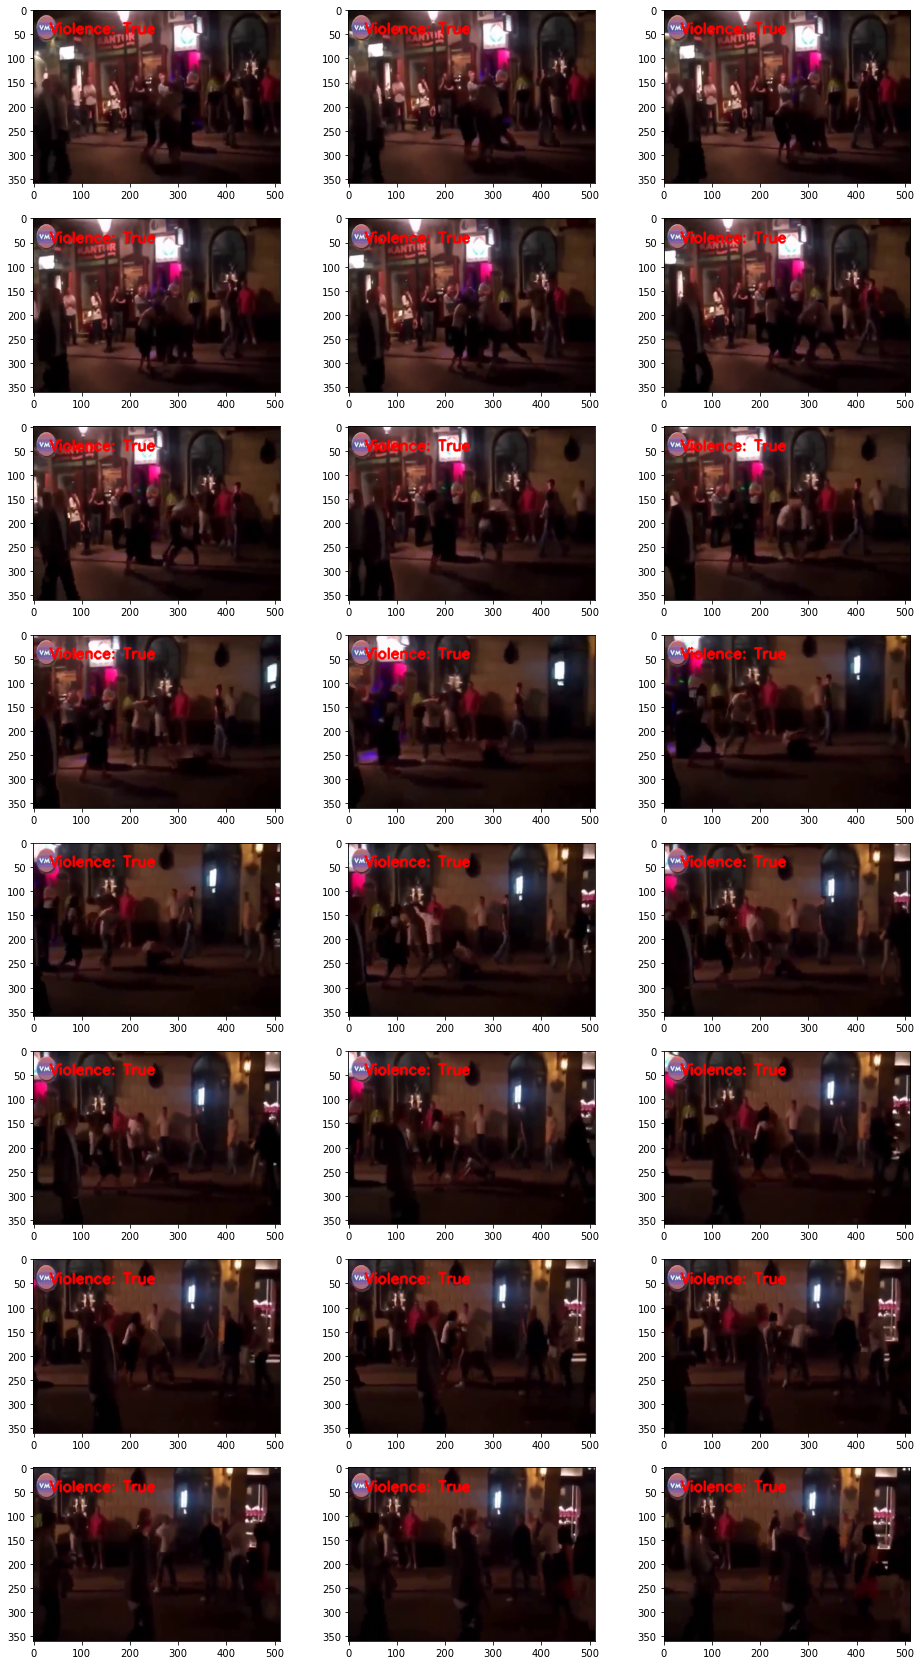

Cleaning up...


In [77]:
print_results(Violence, limit=30)

In [78]:
NonViolence=r"D:/Education/VIT M.Tech/Semester 1/Courses/Study Oriented Project/DataSets/Real Life Violence Dataset/Real Life Violence Dataset/NonViolence/NV_316.mp4"
play(NonViolence)

Loading model ...
1/1 [==============================] - 0s 156ms/step


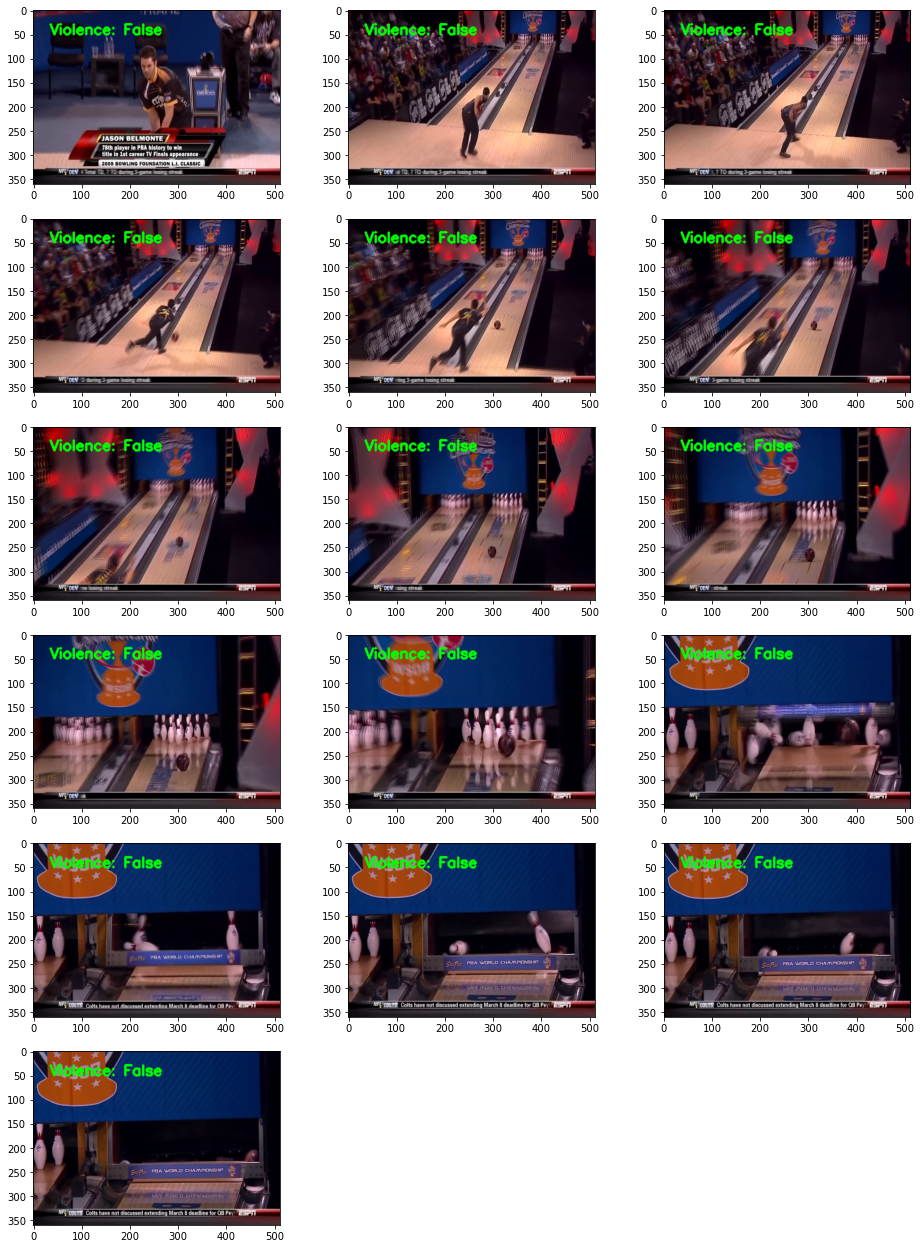

Cleaning up...


In [79]:
print_results(NonViolence, limit=30)

Thus, we have obtained a Violence Detection Surveillance System with high accuracy and very little loss. We use ResNetV2 as it has many attributes which will give the highest accuracy for a model.